In [1]:
import sys
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5]) #This for the polar stereographic plots
from PIL import Image,ImageOps
from datetime import datetime

/scratch/nf33/public/miniconda/envs/digital_earths_env/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# packages
import sys
import numpy as np
import pandas as pd
import os

import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", pd.errors.SettingWithCopyWarning)

In [3]:
user='hs5546' # Username on GADI - if you are storing on /scratch/nf33/user
base_dir=f"/scratch/nf33/{user}/hk25-AusCyclones"
case_dir=f"{base_dir}/ETC_workfolder/Test_month/ETCs_Test_2022_10"
out_dir=f"{case_dir}/stitchNodes"
out_file=f"{out_dir}/stitchNodes.csv"

In [4]:
# directory for TempestExtremes
os.environ['TEMPESTEXTREMESDIR']='/scratch/nf33/tempestextremes/bin'
# link to self-written packages
sys.path.append(base_dir) # change to your directory
from utils.plotting import plot_track, calcu_track_den, lon180to360, plot_den

# link to self-written packages
sys.path.append(f"/scratch/nf33/{user}/hk25-AusCyclones") # change to your directory
from utils.tools import create_Node_dirstruct, write_to_filelist, clear_dir, generate_datetimes
from utils.nci_utils import get_GADI_ERA5_filename
from tempestextremes_utils.node_utils import run_detectNodes, run_stitchNodes

In [5]:
# tropical cyclone
column_names = ["track_id", "year", "month", "day", "hour", "i", "j", "lon", "lat", "msl", "wind", "zs"]
track_df = pd.read_csv(out_file, names=column_names, skiprows=[0],low_memory=False)
track_df['time'] = pd.to_datetime(track_df[['year', 'month', 'day', 'hour']])

In [6]:
track_df

,track_id,year,month,day,hour,i,j,lon,lat,msl,wind,zs,time
0,0,2022,10,1,0,1370,17,162.50,85.75,99031.59,0.541719,NaN,2022-10-01 00:00:00
1,0,2022,10,1,6,1323,17,150.75,85.75,99159.09,0.267026,NaN,2022-10-01 06:00:00
2,0,2022,10,1,12,1296,20,144.00,85.00,99290.52,-1.014875,NaN,2022-10-01 12:00:00
3,0,2022,10,1,18,1288,25,142.00,83.75,99351.12,-0.099231,NaN,2022-10-01 18:00:00
4,0,2022,10,2,0,1304,29,146.00,82.75,99477.30,1.274234,NaN,2022-10-02 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5612,491,2022,11,29,18,1114,551,98.50,-47.75,98636.87,0.083897,NaN,2022-11-29 18:00:00
5613,491,2022,11,30,0,1126,557,101.50,-49.25,98121.03,-0.190796,NaN,2022-11-30 00:00:00
5614,491,2022,11,30,6,1139,562,104.75,-50.50,97790.21,-0.190796,NaN,2022-11-30 06:00:00
5615,491,2022,11,30,12,1154,568,108.50,-52.00,97540.23,0.083897,NaN,2022-11-30 12:00:00


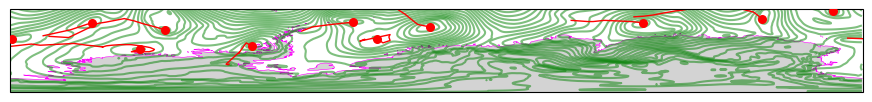

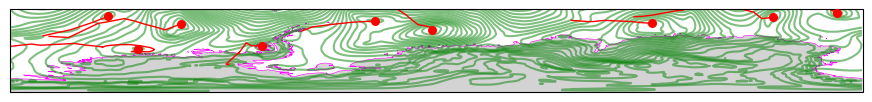

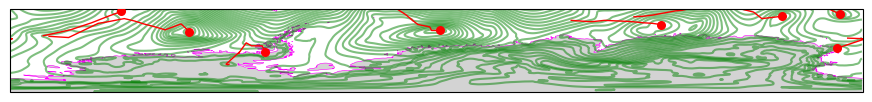

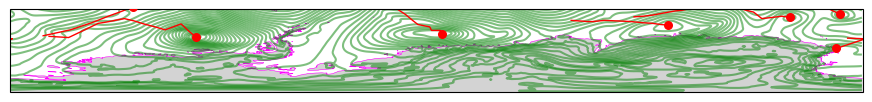

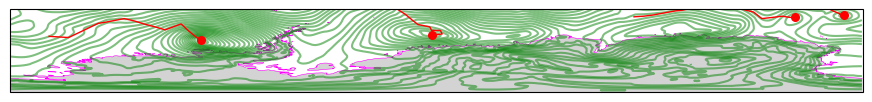

In [12]:
for dt in generate_datetimes(datetime(2022,10,16),datetime(2022,10,17),interval=6):

    projection=ccrs.PlateCarree()
    
    #dt=datetime(1980,1,7,6)
    mslfile = get_GADI_ERA5_filename('msl',dt,stream='hourly',level_type='single-levels')
    msl=xr.open_dataset(mslfile).sel(time=dt)/100
    
    track_df_dt=track_df[track_df.time==dt]
    track_df_todt=track_df[track_df.time<=dt]
    track_id_dt=track_df_dt.track_id.to_list()
    xcom_dt=track_df_dt.lon.to_list()
    ycom_dt=track_df_dt.lat.to_list()
    #obj_xr_dt=obj_xr.sel(time=dt)
        
    ################################################################################################################
    
    figsize=(11,8)
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw=dict(projection=projection)) 
    
    if projection==ccrs.PlateCarree():
        ax.set_extent([-180,180,-90,-55],crs=ccrs.PlateCarree())
    else:
        ax.set_boundary(map_circle, transform=ax.transAxes)
    
    ax.add_feature(LAND,facecolor='lightgrey')
    ax.coastlines(linewidths=0.4, color = 'magenta')
    
    ax.contour(msl.longitude,msl.latitude,msl.msl,colors='green',levels=range(880,1060,4),alpha = 0.5)
    
    for t in track_id_dt:
        track_to_dt=track_df_todt[track_df_todt.track_id==t]
        xtrack_com=track_to_dt.lon.to_list()
        ytrack_com=track_to_dt.lat.to_list()
        ax.plot(xtrack_com,ytrack_com,color='red',linewidth=1,transform=ccrs.Geodetic())
            
    ax.scatter(xcom_dt,ycom_dt,c='red',s=30,transform=ccrs.PlateCarree(),zorder=10)
    #ax.set_title(image_desc+' on '+dt.strftime('%Y-%m-%d %H:%M:%S'))
    
    plt.show()

In [14]:
for t in track_id_dt:
    track_to_dt=track_df_todt[track_df_todt.track_id==t]
    track_com=track_to_dt.mass_center_coords.to_list()
    xtrack_com=[c[0] for c in track_com]
    ytrack_com=[c[1] for c in track_com]
    ax.plot(xtrack_com,ytrack_com,color='black',linewidth=1,transform=ccrs.Geodetic())
        
ax.scatter(xcom_dt,ycom_dt,c='black',s=30,transform=ccrs.PlateCarree())
# ax.set_title(image_desc+' on '+dt.strftime('%Y-%m-%d %H:%M:%S'))

if outfileprefix is not None:
    outfile=outpath+outfileprefix+'_'+dt.strftime('%Y%m%d%H%M%S')+'.jpg'
    plt.savefig(outfile, dpi=dpi)
    crop(outfile,padding=10)
    
plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 2116


AttributeError: 'DataFrame' object has no attribute 'mass_center_coords'

**Visualization 1**  
`plot_track`(df, track_color, fig_title)  
plot tracks  

Parameters:
- **df** - cyclone tracks dataframe (pandas dataframe)
- **track_color** - track color (string)
- **fig_title** - figure title (string)

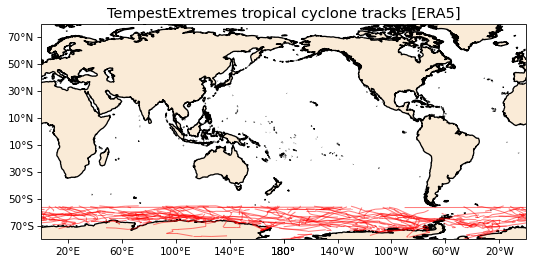

In [7]:
fig = plot_track(track_df.where(track_df.lat<-55), 'red', 'TempestExtremes tropical cyclone tracks [ERA5]')

**Visualization 2**  
`calcu_track_den`(min_lon, max_lon, min_lat, min_lat, max_lat, delta, df_track, storm_id_field, grid_id_field, lonname, latname)  
calculate track density from cyclone tracks  

Parameters:
- **min_lon** - minimum longitude
- **max_lon** - maximum longitude
- **min_lat** - minimum latitude
- **max_lat** - maximum latitude
- **delta** - horizontal grid spacing
- **df_track** - cyclone tracks dataframe (pandas dataframe)
- **storm_id_field** - cyclone track ID number (string)
- **grid_id_field** - "grid_id_field" default
- **lonname** - name of longitude of cyclone track (string)
- **latname** - name of latitude of cyclone track (string)

In [ ]:
dftc['lon'] = [lon180to360(lon) for lon in dftc['lon']]
dstc = calcu_track_den(0, 360, -80, 80, 1, dftc, 'track_id', 'gridid', 'lon', 'lat')

**Visualization 3**  
`plot_den`(dataArray, minlon, maxlon, minlat, maxlat, count_range, sigma, mycmap, title)  
plot track density

Parameters:
- **dataArray** - 2-D density array (xrarry data array)
- **min_lon** - minimum longitude
- **max_lon** - maximum longitude
- **min_lat** - minimum latitude
- **max_lat** - maximum latitude
- **count_range** - colorbar levels (numpy array)
- **sigma** - degree of smooth (1~5)
- **mycmap** - name of longitude of cyclone track (string)
- **title** - figure title (string)

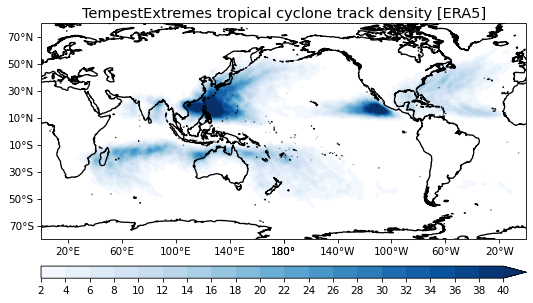

In [ ]:
fig = plot_den(dstc['number'], 0, 360, -80, 80, np.arange(2, 42, 2), 1, 'Blues', 'TempestExtremes tropical cyclone track density [ERA5]')